In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from modules.stn import STN
from modules.gridgen import CylinderGridGen, AffineGridGen
from PIL import Image
from matplotlib import mlab
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

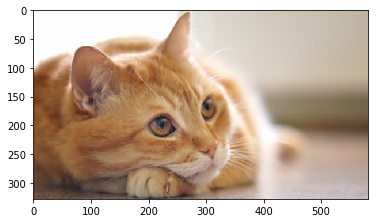

In [67]:
img = Image.open('cat.jpg').convert('RGB')
img = np.array(img)/255.0
plt.imshow(img)

In [69]:
img_batch = np.expand_dims(img, 0)
inputImages = torch.from_numpy(img_batch.astype(np.float32))
inputImages.size()
s = STN()
g = AffineGridGen(328, 582)
input = Variable(torch.from_numpy(np.array([[[1, 0.5, 0], [0.5, 1, 0]]], dtype=np.float32)).cuda(), requires_grad = True)
out = g(input).repeat(20,1,1,1)

input1 = Variable(inputImages.cuda()).repeat(20,1,1,1)
res = s(input1, out)
#print res.size()
#res = res.cpu().data.numpy()

In [76]:
target = Variable(res.data.cuda())

In [77]:
crt = nn.L1Loss()

In [78]:
loss = crt(res, target)

In [79]:
loss.backward()

In [80]:
print input.grad

Variable containing:
(0 ,.,.) = 
 -0.3326 -0.0469 -0.2243
 -0.0819 -0.5957  0.1721
[torch.cuda.FloatTensor of size 1x2x3 (GPU 0)]



In [81]:
input = Variable(torch.from_numpy(np.array([[[1, 0.5, 0], [0.5, 1, 0]]], dtype=np.float32)).cuda(), requires_grad = True)
out = g(input).repeat(20,1,1,1)
out.backward(out.data)

In [82]:
print input.grad

Variable containing:
(0 ,.,.) = 
1.00000e+06 *
   1.2727  0.6363 -0.0149
   0.6363  1.2727 -0.0124
[torch.cuda.FloatTensor of size 1x2x3 (GPU 0)]



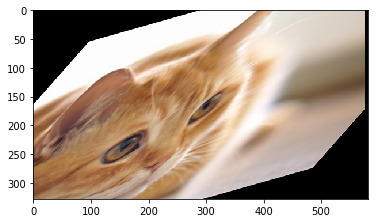

In [83]:
plt.imshow(res.cpu().data.numpy()[1])

In [129]:
target = Variable(res.data.cuda())[0:1,:,:,:]

In [85]:
print input1.size(), target.size()

torch.Size([20, 328, 582, 3]) torch.Size([20, 328, 582, 3])


In [86]:
crt = nn.L1Loss().cuda()
crt2 = nn.L1Loss().cuda()

In [87]:
crt.forward(input1, target)

Variable containing:
 0.2779
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [88]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.s = STN()
        self.g = AffineGridGen(328, 582, lr = 0.01)
    def forward(self,input1, input2):
        out = self.g(input2)
        out2 = self.s(input1, out)
        return out2

In [89]:
t = Transformer()

In [133]:
x = np.arange(0.1, 2, 0.01)
y = []
g_ = []
input1 = Variable(inputImages.cuda())

for v in x:
    input2 = Variable(torch.from_numpy(np.array([[[1, 0.5, 0], [0.48, v, 0]]], dtype=np.float32)).cuda() , requires_grad = True)
    out = t(input1, input2)
    err = crt(out, target)
    y.append(err.data[0])
    err.backward()
    
    #print input2.grad.size()
    g_.append(input2.grad.data[0,1,1])


In [134]:
print input1.size()
print input2.size()

torch.Size([1, 328, 582, 3])
torch.Size([1, 2, 3])


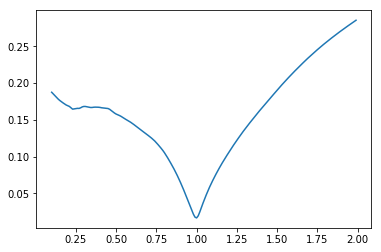

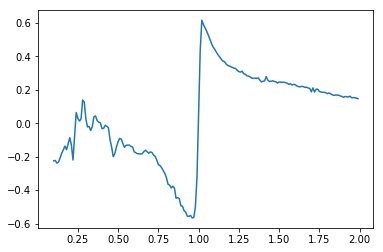

In [135]:
plt.figure()
plt.plot(x,y)
plt.figure()
plt.plot(x,g_)